# Proyecto 01 - Parte 02
**Caso aplicativo**
El estudio “CineVision Studios” está complacido con lo que descubrió en el análisis exploratorio que su equipo le entregó. Sin embargo, le han surgido nuevas interrogantes. En la conformación de su equipo de Data Science, uno de los candidatos, en las entrevistas le ha comentado que existen algoritmos que permiten detectar patrones no evidentes en los datos que le proporcionó y “juntar” variables para que
sea más pequeño. Le ha pedido que indague un poco más en los datos y extraiga información interesante.

## Procesamiento

### Ingesta de datos

In [11]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pyclustertend
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from mlxtend.frequent_patterns import apriori, association_rules
import re
from mlxtend.preprocessing import TransactionEncoder

file_path = "./movies.csv"
df = pd.read_csv(file_path, encoding="latin1")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   budget                     10000 non-null  int64  
 2   genres                     9947 non-null   object 
 3   homePage                   4193 non-null   object 
 4   productionCompany          9543 non-null   object 
 5   productionCompanyCountry   8720 non-null   object 
 6   productionCountry          9767 non-null   object 
 7   revenue                    10000 non-null  float64
 8   runtime                    10000 non-null  int64  
 9   video                      9514 non-null   object 
 10  director                   9926 non-null   object 
 11  actors                     9920 non-null   object 
 12  actorsPopularity           9913 non-null   object 
 13  actorsCharacter            9953 non-null   obje

### Normalización de datos

In [ ]:

df = df.replace(r'^\s*$', np.nan, regex=True)

def clean_numeric(cell):
    if pd.isna(cell):
        return np.nan
    if isinstance(cell, str) and '|' in cell:
        cell = cell.split('|')[0]
    cell_clean = re.sub(r'[^0-9\.\-]', '', str(cell))
    try:
        return float(cell_clean)
    except:
        return np.nan

def is_numeric_column(series, threshold=0.8):
    non_null = series.dropna()
    if len(non_null) == 0:
        return False
    numeric_count = 0
    for val in non_null:
       
        if isinstance(val, str) and '|' in val:
            val = val.split('|')[0]
       
        val_clean = re.sub(r'[^0-9\.\-]', '', str(val))
        try:
            float(val_clean)
            numeric_count += 1
        except:
            pass
    return (numeric_count / len(non_null)) >= threshold

numeric_cols = [col for col in df.columns if is_numeric_column(df[col])]

for col in numeric_cols:
    df[col] = df[col].apply(clean_numeric)

def split_pipe(cell):
    if pd.isna(cell):
        return cell
    if isinstance(cell, str) and '|' in cell:
        return cell.split('|')
    return cell

non_numeric_cols = [col for col in df.columns if col not in numeric_cols]
for col in non_numeric_cols:
    df[col] = df[col].apply(split_pipe)

df.to_csv('data_clean.csv', index=False, encoding='utf-8')

     id      budget                                genres  \
0   5.0   4000000.0                       [Crime, Comedy]   
1   6.0  21000000.0             [Action, Thriller, Crime]   
2  11.0  11000000.0  [Adventure, Action, Science Fiction]   
3  12.0  94000000.0                   [Animation, Family]   
4  13.0  55000000.0              [Comedy, Drama, Romance]   

                                            homePage  \
0          https://www.miramax.com/movie/four-rooms/   
1                                                NaN   
2  http://www.starwars.com/films/star-wars-episod...   
3              http://movies.disney.com/finding-nemo   
4                                                NaN   

                                productionCompany productionCompanyCountry  \
0                         [Miramax, A Band Apart]                 [US, US]   
1  [Universal Pictures, Largo Entertainment, JVC]             [US, US, JP]   
2                   [Lucasfilm, 20th Century Fox]             

### Selección de variables

In [9]:
numeric_columns = ["actorsPopularity", "castWomenAmount", "castMenAmount"]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

features = [
    'popularity', 'budget', 'revenue', 'runtime', 'voteCount', 'voteAvg',
    'genresAmount', 'productionCoAmount', 'productionCountriesAmount',
    'actorsPopularity', 'actorsAmount', 'castWomenAmount', 'castMenAmount'
]

X = df[features].dropna()

scaler_global = StandardScaler()
X_scaled = scaler_global.fit_transform(X)

print("Forma de X_scaled:", X_scaled.shape)

df_scaled = pd.DataFrame(X_scaled, columns=features)
print("Vista previa de los datos globalmente estandarizados:")
print(df_scaled.head())

df_scaled.to_csv("movies_normalized.csv", index=False)

Forma de X_scaled: (9784, 13)
Vista previa de los datos globalmente estandarizados:
   popularity    budget   revenue   runtime  voteCount   voteAvg  \
0   -0.140011 -0.404818 -0.355605 -0.123225   0.273022 -0.828680   
1   -0.191588  0.055987 -0.303408  0.333830  -0.444273  0.010062   
2    0.221643 -0.215075  4.752680  0.752796   5.891057  1.792390   
3    0.379024  2.034738  5.845279 -0.047049   5.631840  1.373018   
4    0.033089  0.977597  4.103428  1.552642   7.998448  2.106918   

   genresAmount  productionCoAmount  productionCountriesAmount  \
0     -0.540547           -0.505237                  -0.248447   
1      0.342376           -0.063403                   0.084951   
2      0.342376           -0.505237                  -0.248447   
3     -0.540547           -0.947071                  -0.248447   
4      0.342376           -0.505237                  -0.248447   

   actorsPopularity  actorsAmount  castWomenAmount  castMenAmount  
0          0.679417     -0.124215        -

In [10]:
# Variables consideradas por análisis como relevantes agruparlas para su estudio
features_rendimiento = ['popularity', 'voteCount', 'voteAvg']
features_financiero  = ['budget', 'revenue']
features_produccion  = ['runtime', 'genresAmount', 'productionCoAmount', 'productionCountriesAmount']
features_reparto     = ['actorsPopularity', 'actorsAmount', 'castWomenAmount', 'castMenAmount']

def preparar_subconjunto(dataframe, features):
    data = dataframe[features].dropna()
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, scaler, data.index

data_rendimiento, scaler_rendimiento, indices_rendimiento = preparar_subconjunto(df, features_rendimiento)
data_financiero, scaler_financiero, indices_financiero   = preparar_subconjunto(df, features_financiero)
data_produccion, scaler_produccion, indices_produccion   = preparar_subconjunto(df, features_produccion)
data_reparto, scaler_reparto, indices_reparto             = preparar_subconjunto(df, features_reparto)


## Análsis de la tendencia de agrupamiento

### Estadístico de Hopkins y VAT (Grupo de variables y subgrupos)

#### Global

In [11]:
from sklearn.neighbors import NearestNeighbors

def hopkins(X):
    X = np.array(X)
    n, d = X.shape
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    rand_X = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (m, d))
    ujd = []
    wjd = []
    for j in range(m):
        u_dist, _ = nbrs.kneighbors([rand_X[j]], 2, return_distance=True)
        random_index = np.random.randint(0, n)
        w_dist, _ = nbrs.kneighbors([X[random_index]], 2, return_distance=True)
        ujd.append(u_dist[0][1])
        wjd.append(w_dist[0][1])
    H = np.sum(ujd) / (np.sum(ujd) + np.sum(wjd))
    return H

hopkins_global = hopkins(X_scaled)
print("Hopkins Global:", hopkins_global)


Hopkins Global: 0.9872584702242246


#### Subgrupos (Variables destacadas)

In [12]:
groups = {
    'Rendimiento': data_rendimiento,
    'Financiero': data_financiero,
    'Produccion': data_produccion,
    'Reparto': data_reparto
}

for name, data in groups.items():
    print(f"Hopkins {name}:", hopkins(data))

Hopkins Rendimiento: 0.9950132321163351
Hopkins Financiero: 0.9923106342416192
Hopkins Produccion: 0.9972112289968638
Hopkins Reparto: 0.9996704352410705


## Número Óptimo de Clústeres 

#### Global

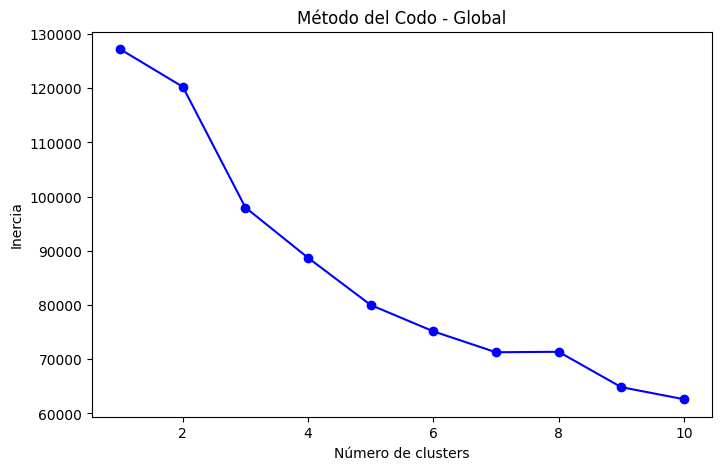

In [13]:
inertia_global = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia_global.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), inertia_global, 'bo-')
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.title("Método del Codo - Global")
plt.show()

#### Subgrupos (Variables destacadas)

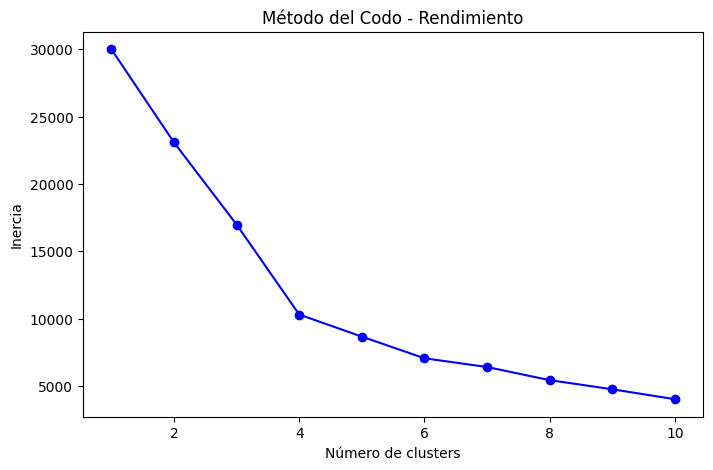

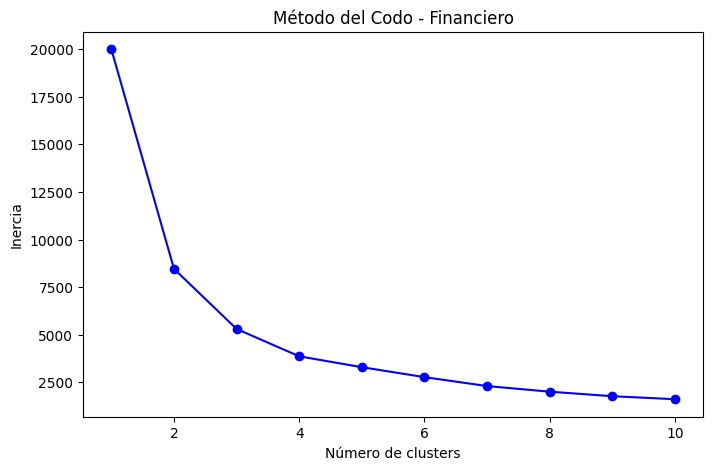

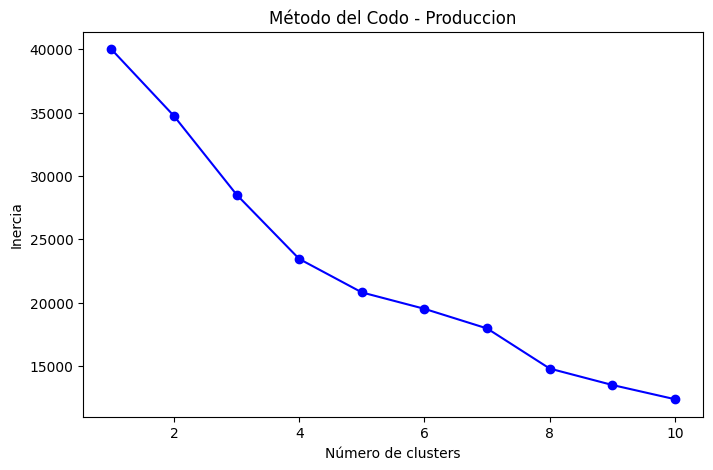

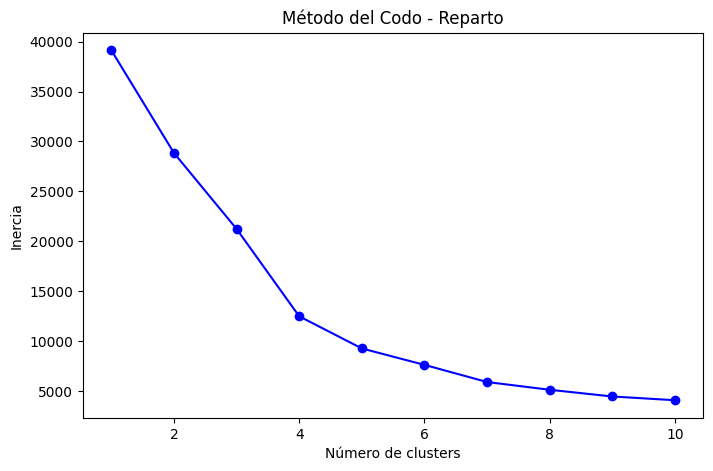

In [14]:
for name, data in groups.items():
    inertia_group = []
    for k in range(1, 11):
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(data)
        inertia_group.append(km.inertia_)
    plt.figure(figsize=(8,5))
    plt.plot(range(1, 11), inertia_group, 'bo-')
    plt.xlabel("Número de clusters")
    plt.ylabel("Inercia")
    plt.title(f"Método del Codo - {name}")
    plt.show()

## Clustering con K-Means y Clustering Jerárquico

In [15]:
optimal_k_global = 4
km_global = KMeans(n_clusters=optimal_k_global, random_state=42)
clusters_global = km_global.fit_predict(X_scaled)
df.loc[X.index, 'Cluster_Global_KMeans'] = clusters_global

agglo_global = AgglomerativeClustering(n_clusters=optimal_k_global, linkage='ward')
clusters_global_agglo = agglo_global.fit_predict(X_scaled)
df.loc[X.index, 'Cluster_Global_Agglo'] = clusters_global_agglo

print(df[['Cluster_Global_KMeans', 'Cluster_Global_Agglo']].head(10))

   Cluster_Global_KMeans  Cluster_Global_Agglo
0                    0.0                   1.0
1                    0.0                   1.0
2                    2.0                   0.0
3                    2.0                   0.0
4                    2.0                   0.0
5                    2.0                   1.0
6                    2.0                   0.0
7                    0.0                   1.0
8                    2.0                   0.0
9                    0.0                   1.0


#### Subgrupos (Variables destacadas)

In [20]:
group_optimal = {
    'Rendimiento': 4,
    'Financiero': 3,
    'Produccion': 5,
    'Reparto': 4
}

for name, data in groups.items():
    k = group_optimal[name]
    km = KMeans(n_clusters=k, random_state=42)
    clusters = km.fit_predict(data)
    agglo = AgglomerativeClustering(n_clusters=k, linkage='ward')
    clusters_agglo = agglo.fit_predict(data)
    if name == 'Rendimiento':
        idx = indices_rendimiento
    elif name == 'Financiero':
        idx = indices_financiero
    elif name == 'Produccion':
        idx = indices_produccion
    elif name == 'Reparto':
        idx = indices_reparto
    df.loc[idx, f'Cluster_{name}_KMeans'] = clusters
    df.loc[idx, f'Cluster_{name}_Agglo'] = clusters_agglo
    

print(df[['Cluster_Rendimiento_KMeans', 'Cluster_Rendimiento_Agglo',
          'Cluster_Financiero_KMeans', 'Cluster_Financiero_Agglo',
          'Cluster_Produccion_KMeans', 'Cluster_Produccion_Agglo',
          'Cluster_Reparto_KMeans', 'Cluster_Reparto_Agglo']].head(10))

   Cluster_Rendimiento_KMeans  Cluster_Rendimiento_Agglo  \
0                         1.0                        1.0   
1                         0.0                        0.0   
2                         2.0                        2.0   
3                         2.0                        2.0   
4                         2.0                        2.0   
5                         2.0                        2.0   
6                         0.0                        0.0   
7                         0.0                        0.0   
8                         2.0                        2.0   
9                         0.0                        0.0   

   Cluster_Financiero_KMeans  Cluster_Financiero_Agglo  \
0                        1.0                       1.0   
1                        1.0                       1.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        0.0                     

## Evaluación de la Calidad del Agrupamiento (Silhouette Plot)

#### Global

For n_clusters = 4 Global silhouette score: 0.1645430996292847


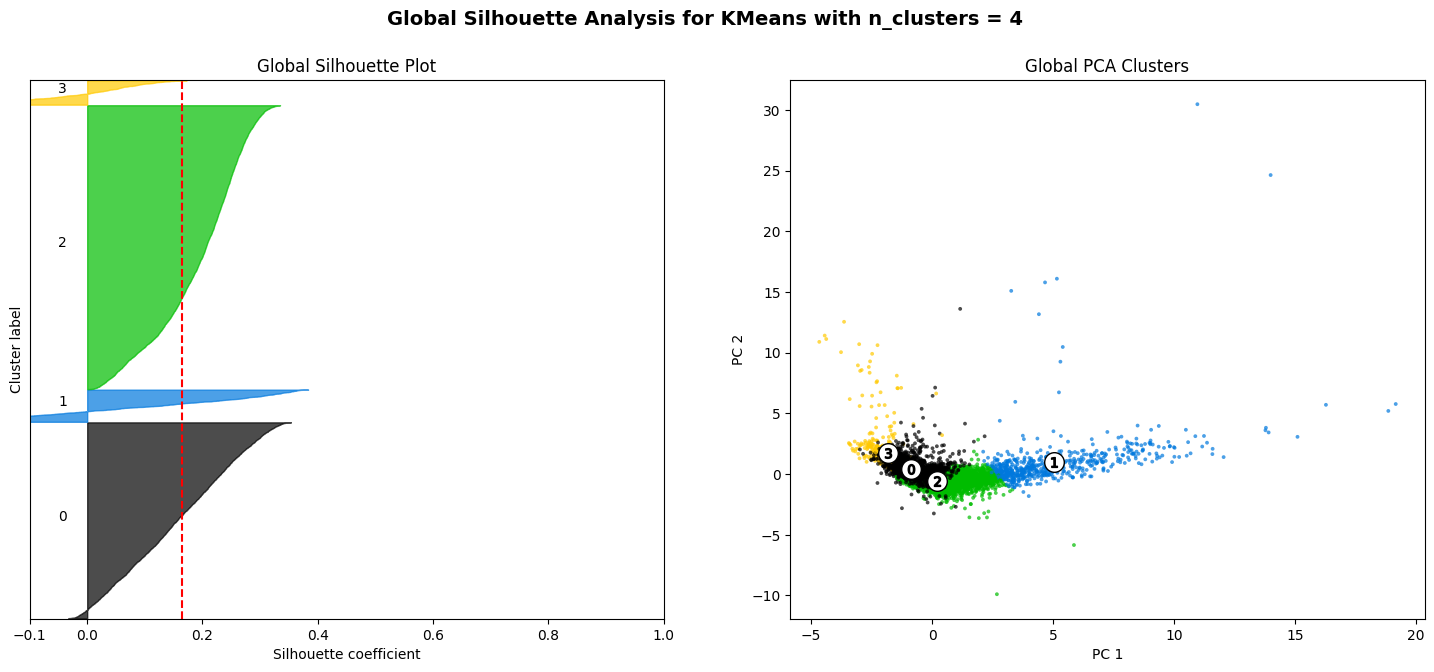

In [21]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [4]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, X_scaled.shape[0] + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters =", n_clusters, "Global silhouette score:", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_values = sample_silhouette_values[cluster_labels == i]
        ith_values.sort()
        size_i = ith_values.shape[0]
        y_upper = y_lower + size_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_title("Global Silhouette Plot")
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7,
                c=colors, edgecolor="k")
    centers = clusterer.cluster_centers_
    centers_pca = pca.transform(centers)
    ax2.scatter(centers_pca[:, 0], centers_pca[:, 1], marker="o", c="white",
                alpha=1, s=200, edgecolor="k")
    for i, c in enumerate(centers_pca):
        ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")
    ax2.set_title("Global PCA Clusters")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")
    
    plt.suptitle("Global Silhouette Analysis for KMeans with n_clusters = %d" % n_clusters,
                 fontsize=14, fontweight="bold")
    plt.show()


#### Subgrupos (Variables destacadas)

For Rendimiento with n_clusters = 4, silhouette score: 0.4182019444876601


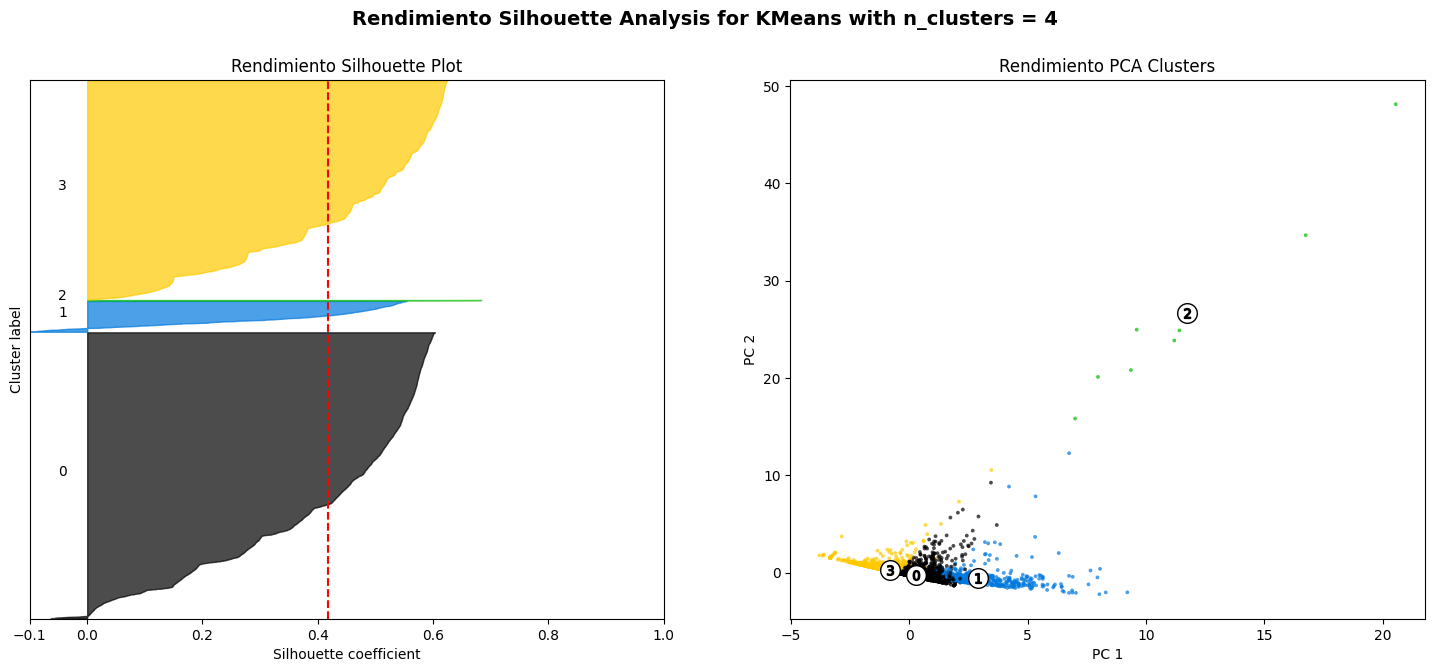

For Financiero with n_clusters = 3, silhouette score: 0.7396924943149752


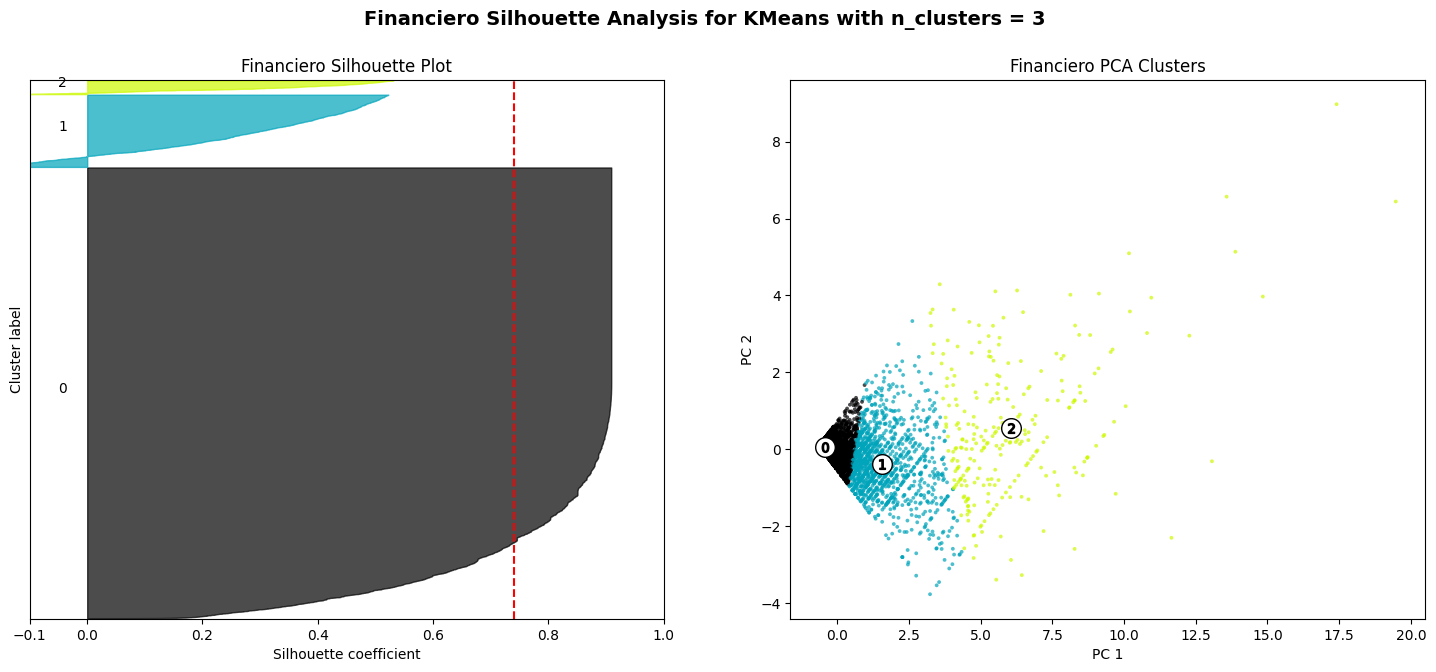

For Produccion with n_clusters = 4, silhouette score: 0.20441766341633033


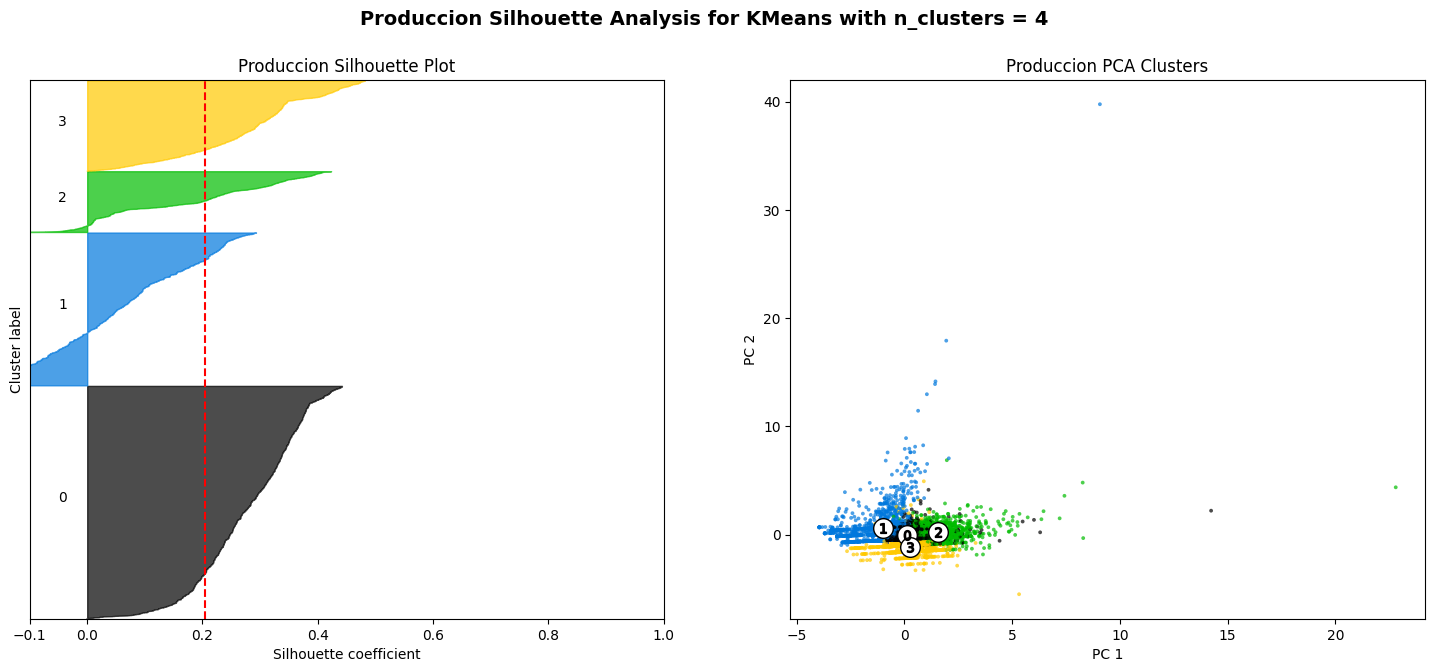

For Reparto with n_clusters = 3, silhouette score: 0.4645942134931582


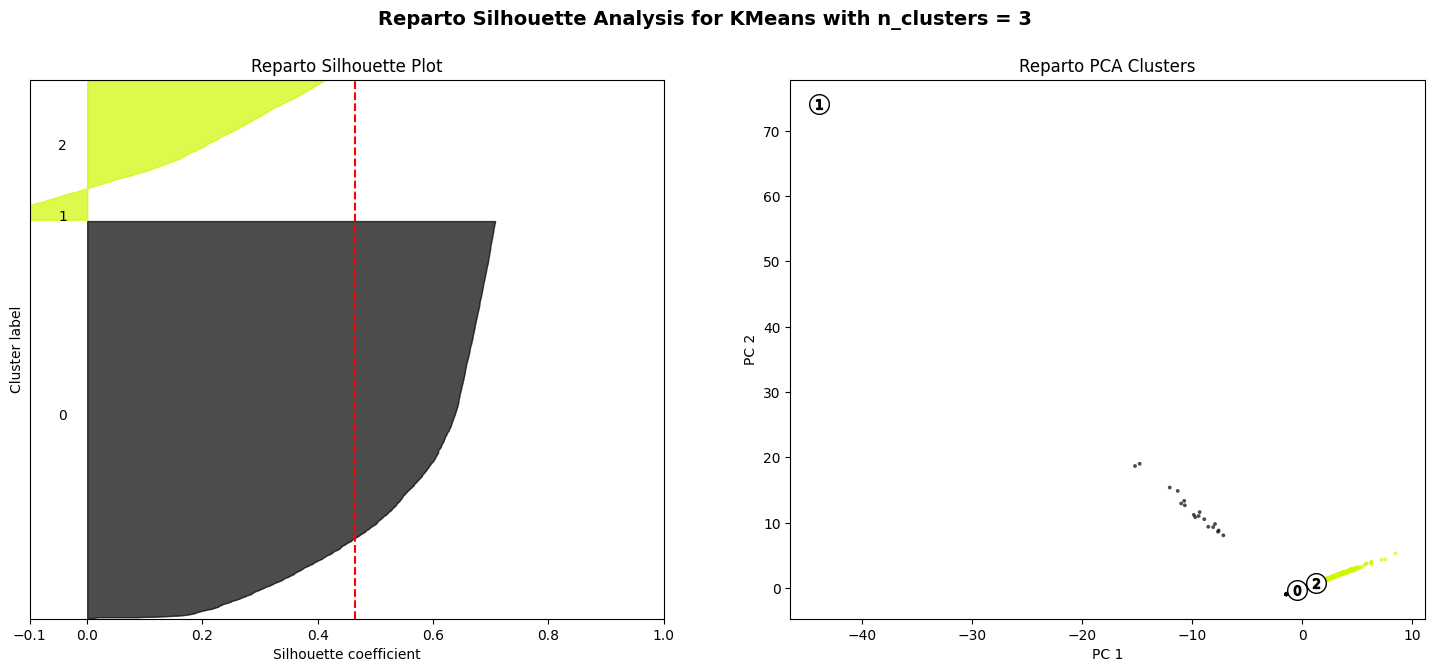

In [18]:
for name, data in groups.items():
    n_clusters = group_optimal[name]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, data.shape[0] + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    print(f"For {name} with n_clusters = {n_clusters}, silhouette score:", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_values = sample_silhouette_values[cluster_labels == i]
        ith_values.sort()
        size_i = ith_values.shape[0]
        y_upper = y_lower + size_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_title(f"{name} Silhouette Plot")
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(data)
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7,
                c=colors, edgecolor="k")
    centers = clusterer.cluster_centers_
    centers_pca = pca.transform(centers)
    ax2.scatter(centers_pca[:, 0], centers_pca[:, 1], marker="o", c="white",
                alpha=1, s=200, edgecolor="k")
    for i, c in enumerate(centers_pca):
        ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")
    ax2.set_title(f"{name} PCA Clusters")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")
    
    plt.suptitle(f"{name} Silhouette Analysis for KMeans with n_clusters = {n_clusters}",
                 fontsize=14, fontweight="bold")
    plt.show()


## PCA

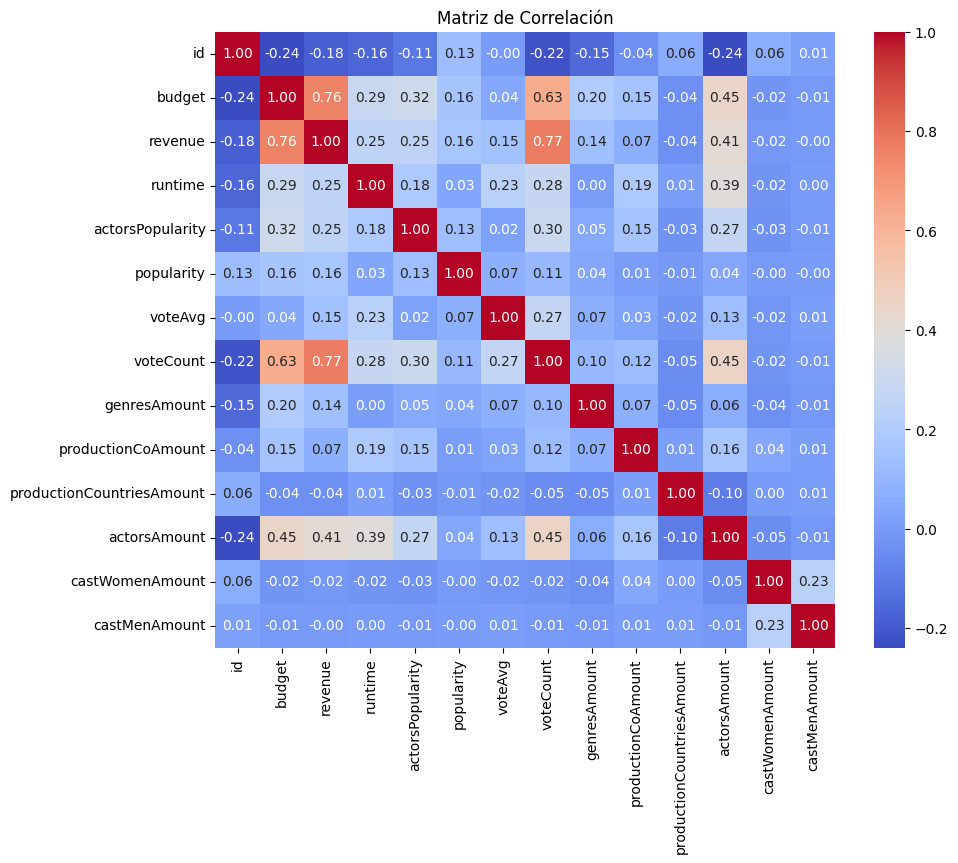

Índice KMO: 0.7600612908534091
Test de esfericidad de Bartlett: chi2 = 28541.533892631607 p-value = 0.0


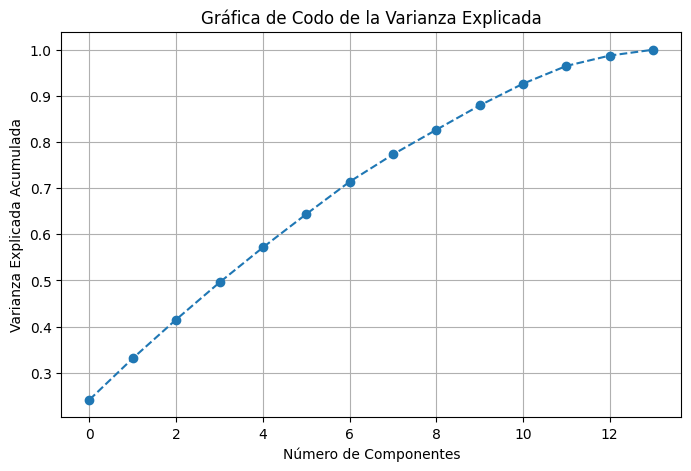

Número de componentes seleccionados para explicar al menos el 80% de la varianza: 9
Cargas (coeficientes) de los Componentes Principales:
                                PC1       PC2       PC3       PC4       PC5  \
id                        -0.195970  0.321198  0.459351  0.252124 -0.033175   
budget                     0.450115  0.022393  0.106686 -0.221049 -0.116639   
revenue                    0.453036  0.058252  0.197008 -0.193642  0.051727   
runtime                    0.277472  0.034441 -0.259526  0.486933  0.062487   
actorsPopularity           0.255506  0.051125  0.045124  0.059381 -0.431180   
popularity                 0.102522  0.235301  0.630488  0.045316 -0.086842   
voteAvg                    0.145934  0.083456  0.061180  0.444204  0.680840   
voteCount                  0.453331  0.050430  0.110890 -0.056682  0.125983   
genresAmount               0.123452 -0.184964 -0.029246 -0.378024  0.169131   
productionCoAmount         0.137817  0.123391 -0.296766  0.303796 -0.412

In [22]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


file_path = "./data_clean.csv"
df = pd.read_csv(file_path, encoding="latin1")

numeric_cols = df.select_dtypes(include=[np.number]).columns
X = df[numeric_cols].dropna()  

corr_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

kmo_all, kmo_model = calculate_kmo(X)
print("Índice KMO:", kmo_model)

chi_square_value, p_value = calculate_bartlett_sphericity(X)
print("Test de esfericidad de Bartlett: chi2 =", chi_square_value, "p-value =", p_value)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Gráfica de Codo de la Varianza Explicada')
plt.grid(True)
plt.show()

n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.8) + 1
print("Número de componentes seleccionados para explicar al menos el 80% de la varianza:", n_components)

pca_final = PCA(n_components=n_components)
components_final = pca_final.fit_transform(X_scaled)

loadings = pd.DataFrame(pca_final.components_.T, 
                        columns=[f'PC{i+1}' for i in range(n_components)], 
                        index=numeric_cols)
print("Cargas (coeficientes) de los Componentes Principales:")
print(loadings)


## Reglas de asociación

### Preparación de Datos Transaccionales

#### Generos

In [17]:
df_assoc = df.copy()

df['genres_list'] = df['genres'].fillna("").apply(lambda x: x.split("|") if x != "" else [])

from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_array = te.fit(df['genres_list'].tolist()).transform(df['genres_list'].tolist())
df_trans = pd.DataFrame(te_array, columns=te.columns_)

print("Vista previa del DataFrame transaccional (one-hot):")
print(df_trans.head())


Vista previa del DataFrame transaccional (one-hot):
   Action  Adventure  Animation  Comedy  Crime  Documentary  Drama  Family  \
0   False      False      False    True   True        False  False   False   
1    True      False      False   False   True        False  False   False   
2    True       True      False   False  False        False  False   False   
3   False      False       True   False  False        False  False    True   
4   False      False      False    True  False        False   True   False   

   Fantasy  History  Horror  Music  Mystery  Romance  Science Fiction  \
0    False    False   False  False    False    False            False   
1    False    False   False  False    False    False            False   
2    False    False   False  False    False    False             True   
3    False    False   False  False    False    False            False   
4    False    False   False  False    False     True            False   

   TV Movie  Thriller    War  Western  


#### productionCountry 

In [18]:
df['prodCountry_list'] = df['productionCountry'].fillna("").apply(lambda x: x.split("|") if x != "" else [])

te_pc = TransactionEncoder()
te_array_pc = te_pc.fit(df['prodCountry_list'].tolist()).transform(df['prodCountry_list'].tolist())
df_trans_pc = pd.DataFrame(te_array_pc, columns=te_pc.columns_)

frequent_itemsets_pc = apriori(df_trans_pc, min_support=0.05, use_colnames=True)
rules_pc = association_rules(frequent_itemsets_pc, metric="confidence", min_threshold=0.6)

print("Reglas de asociación para productionCountry:")
print(rules_pc.sort_values(by="confidence", ascending=False).head(10))


Reglas de asociación para productionCountry:
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


### Construir Reglas de Asociación (Global)

In [21]:

frequent_itemsets = apriori(df_trans, min_support=0.05, use_colnames=True)
print("Conjuntos frecuentes (soporte mínimo 0.05):")
print(frequent_itemsets.sort_values(by="support", ascending=False).head())


rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
print("Reglas de asociación (confianza >= 0.6):")
print(rules.sort_values(by="confidence", ascending=False).head())

Conjuntos frecuentes (soporte mínimo 0.05):
    support     itemsets
5    0.3789      (Drama)
3    0.3018     (Comedy)
0    0.2632     (Action)
12   0.2564   (Thriller)
1    0.1769  (Adventure)
Reglas de asociación (confianza >= 0.6):
  antecedents consequents  antecedent support  consequent support  support  \
1   (Mystery)  (Thriller)              0.0803              0.2564   0.0503   
0   (Romance)     (Drama)              0.1428              0.3789   0.0871   

   confidence      lift  representativity  leverage  conviction  \
1    0.626401  2.443062               1.0  0.029711    1.990369   
0    0.609944  1.609776               1.0  0.032993    1.592335   

   zhangs_metric   jaccard  certainty  kulczynski  
1       0.642250  0.175628   0.497581    0.411289  
0       0.441899  0.200414   0.371992    0.419910  


### Diferentes Umbrales

In [7]:
soporte_vals = [0.03, 0.05, 0.07]
confianza_vals = [0.5, 0.6, 0.7]

for soporte in soporte_vals:
    frequent_itemsets = apriori(df_trans, min_support=soporte, use_colnames=True)
    for confianza in confianza_vals:
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=confianza)
        print(f"--- Soporte mínimo: {soporte} | Confianza mínima: {confianza} ---")
        print(rules.sort_values(by="confidence", ascending=False).head())
        print("\n")

--- Soporte mínimo: 0.03 | Confianza mínima: 0.5 ---
                     antecedents  consequents  antecedent support  \
7                      (History)      (Drama)              0.0406   
17           (Animation, Comedy)     (Family)              0.0556   
10  (Adventure, Science Fiction)     (Action)              0.0404   
12        (Adventure, Animation)     (Family)              0.0606   
13           (Adventure, Family)  (Animation)              0.0642   

    consequent support  support  confidence      lift  representativity  \
7               0.3789   0.0358    0.881773  2.327193               1.0   
17              0.1407   0.0424    0.762590  5.419971               1.0   
10              0.2632   0.0304    0.752475  2.858949               1.0   
12              0.1407   0.0406    0.669967  4.761670               1.0   
13              0.1460   0.0406    0.632399  4.331498               1.0   

    leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
7   0.

#### Géneros + Países de Producción

In [22]:
df['combined_list'] = df['genres_list'] + df['prodCountry_list']


te_comb = TransactionEncoder()
te_array_comb = te_comb.fit(df['combined_list'].tolist()).transform(df['combined_list'].tolist())
df_trans_comb = pd.DataFrame(te_array_comb, columns=te_comb.columns_)


frequent_itemsets_comb = apriori(df_trans_comb, min_support=0.05, use_colnames=True)
rules_comb = association_rules(frequent_itemsets_comb, metric="confidence", min_threshold=0.6)

print("Reglas de asociación combinadas (Géneros + Países de Producción):")
print(rules_comb.sort_values(by="confidence", ascending=False).head(10))


Reglas de asociación combinadas (Géneros + Países de Producción):
                              antecedents                 consequents  \
20                       (Family, Comedy)  (United States of America)   
6                                (Family)  (United States of America)   
16                     (Thriller, Action)  (United States of America)   
22                      (Crime, Thriller)  (United States of America)   
17  (Animation, United States of America)                    (Family)   
18                    (Animation, Family)  (United States of America)   
3                                 (Crime)  (United States of America)   
21                      (Romance, Comedy)  (United States of America)   
25                     (Thriller, Horror)  (United States of America)   
15              (Science Fiction, Action)  (United States of America)   

    antecedent support  consequent support  support  confidence      lift  \
20              0.0790              0.6788   0.0670  

#### popularity y voteAvg

In [23]:

df['popularity_category'] = pd.qcut(df['popularity'], q=3, labels=['Baja', 'Media', 'Alta'])
df['vote_category'] = pd.qcut(df['voteAvg'], q=3, labels=['Baja', 'Media', 'Alta'])


df['combined_list_2'] = df['genres_list'] + df['popularity_category'].astype(str).apply(lambda x: [x]) + df['vote_category'].astype(str).apply(lambda x: [x])


te_comb2 = TransactionEncoder()
te_array_comb2 = te_comb2.fit(df['combined_list_2'].tolist()).transform(df['combined_list_2'].tolist())
df_trans_comb2 = pd.DataFrame(te_array_comb2, columns=te_comb2.columns_)


frequent_itemsets_comb2 = apriori(df_trans_comb2, min_support=0.05, use_colnames=True)
rules_comb2 = association_rules(frequent_itemsets_comb2, metric="confidence", min_threshold=0.6)

print("Reglas combinadas (Géneros + Popularidad + Votación):")
print(rules_comb2.sort_values(by="confidence", ascending=False).head(10))


Reglas combinadas (Géneros + Popularidad + Votación):
           antecedents  consequents  antecedent support  consequent support  \
0          (Animation)       (Alta)              0.1460              0.5363   
7   (Thriller, Horror)       (Baja)              0.0748              0.5397   
2             (Horror)       (Baja)              0.1512              0.5397   
5       (Alta, Family)  (Animation)              0.0813              0.1460   
6  (Animation, Family)       (Alta)              0.0813              0.5363   
4            (Mystery)   (Thriller)              0.0803              0.2564   
1            (Fantasy)       (Alta)              0.1284              0.5363   
8     (Media, Romance)      (Drama)              0.0828              0.3789   
3            (Romance)      (Drama)              0.1428              0.3789   

   support  confidence      lift  representativity  leverage  conviction  \
0   0.1042    0.713699  1.330782               1.0  0.025900    1.619622   
7  

### Discusión de las Reglas de Asociación

In [ ]:

rules_interesantes = rules[rules['lift'] > 1.2].sort_values(by='lift', ascending=False)
print("Reglas interesantes (lift > 1.2):")
print(rules_interesantes.head(10))


df["productionCountry"] = df["|"].fillna('prodCountry_list').apply(lambda x: x.split('productionCountry') if x != "" else [])
te_pc = TransactionEncoder()
te_array_pc = te_pc.fit(df["|"].tolist()).transform(df[""].tolist())
df_trans_pc = pd.DataFrame(te_array_pc, columns=te_pc.columns_)

frequent_itemsets_pc = apriori(df_trans_pc, min_support=0.05, use_colnames=True)
rules_pc = association_rules(frequent_itemsets_pc, metric='prodCountry_list', min_threshold=0.6)
print('prodCountry_list')
print(rules_pc.sort_values(by="confidence", ascending=False).head())




Reglas interesantes (lift > 1.2):
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []
Reglas de asociación para productionCountry:
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []
